In this notebook I'm going to analyse the tweet collected and the the most used hashtags by congolese on twitter
For now a simple defintion of a congolese on social media is someone who tweet using the following hashtags : DRC, RDC, RDCongo, DRCongo.

In [2]:
from collections import Counter, defaultdict
import json
from tweets_queries.twitter_query_data import query_tweets

Let analyse a tweet and get the hashtags involed in the tweet

In [3]:
def get_hashtags(tweet):
    entities = tweet.get('entities', {})
    hashtags = entities.get('hashtags', [])
    return [ get_text(tag) for tag in hashtags if get_text(tag) not in ['rdc', 'drc', 'rdcongo', 'drcongo']]

In [4]:
def get_text(tag):
    return tag.get('text').lower()

In [6]:
hastags = Counter()
from tweets_queries.twitter_client import get_twitter_client
client = get_twitter_client()
tweets = query_tweets(client, max_tweets=2000, query=['RDC', 'RDCongo', 'DRC', 'DRCongo'])
for tweet in get_tweets('10-05-2020', '11-05-2020'):
    hashtags_in_tweet = get_hashtags(tweet)
    hastags.update(hashtags_in_tweet)
for tag,count in hastags.most_common(25):
    print("{} : {}".format(tag, count))

proces100j : 70
covid19 : 57
kamerhe : 54
proces : 46
procès : 43
procèsvk : 27
congo : 23
procèskhamere : 16
kinshasa : 15
procesvk : 13
zimbabwe : 13
vitalkamerhe : 12
algeria : 12
rwanda : 10
procèskamerhe : 10
goma : 8
100jours : 8
rdc_proces_kamerhe : 7
deskjustice : 7
jamal_samih : 7
proceskamerhe : 6
coronavirus : 6
progamme100jours : 6
afriquematin : 5
kamehre : 5


let check how our people uses others hastags apart from the one I selected 

In [7]:
hashtag_count = defaultdict(int)
for tweet in get_tweets('10-05-2020', '11-05-2020'):
    hashtags_in_tweet = get_hashtags(tweet)
    n_of_hashtags = len(hashtags_in_tweet)
    hashtag_count[n_of_hashtags] +=1
    tweet_with_hashtags = sum([count for n_of_tags , count in hashtag_count.items() if n_of_tags>0])
    tweet_without_hashtags = hashtag_count[0]
    total_tweet = tweet_with_hashtags + tweet_without_hashtags
print("{} tweets without hashtags  ({}%)".format(tweet_without_hashtags,  tweet_without_hashtags*100/total_tweet)) 
print("{} tweets with at least one hashtag  ({}%)".format(tweet_with_hashtags,  tweet_with_hashtags*100/total_tweet))        

1454 tweets without hashtags  (72.7%)
546 tweets with at least one hashtag  (27.3%)


Conclusion we can see that we have only 92 tweets without hashtags 

### II. Tweet text analysis

In this portion of the notebook we will analyse a tweet as text and perform some NLP tasks on it such tokenization, etc

In [8]:
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import string

In [9]:
def process_text(text, tokenizer= TweetTokenizer(), words_to_remove=[]):
    """
    Process the text of a tweet
    - lowertext
    - stop world 
    - digit removal
    and return a list of strings
    """
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    return [token for token in tokens if token not in words_to_remove and not token.isdigit()]
    

let do the analysis now

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/es.py/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
punctuation  = list(string.punctuation)
stop_word_list_english = stopwords.words('english')
stop_word_list_french = stopwords.words('french')
others_words = ['rt', 'via', '...', '…', '»:', '«:' , '’:', 'les', '-', ]
words_to_remove = punctuation + stop_word_list_english + stop_word_list_french + others_words

In [12]:
term_counts = Counter()
for tweet in get_tweets('10-05-2020', '11-05-2020'):
    tokens = process_text(text=tweet.get('text'), words_to_remove=words_to_remove)
    term_counts.update(tokens)
for tag, count in term_counts.most_common(20):
    print("{}: {}".format(tag, count))

#rdc: 858
’: 537
kamerhe: 486
vital: 401
procès: 345
@vitalkamerhe1: 265
rdc: 227
jamais: 213
jammal: 171
jours: 168
«: 157
@soniarolley: 152
cette: 150
mr: 134
🇨: 114
🇩: 113
@presidence_rdc: 112
connaître: 110
@stanysbujakera: 110
programme: 107


We can see that we need to update our list of stop words and punctuations world like '»:', '»:' , '’:' should be removed

For now we can remove them manually , and next time we will find a way to deal wit those kind of puctuation as weel as contractions

#### III. Term frequency

*The following graph will plot the term frequency of words vs his position within the ranking term*

In [13]:
y = [count for tag, count in term_counts.most_common(100)]
x = range(1, len(y)+1)

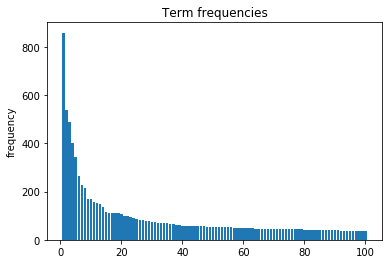

In [14]:
plt.bar(x, y)
plt.title("Term frequencies")
plt.ylabel('frequency')
plt.savefig('../images/term_distribution.png')

How can we explain this figure?
The figure shows a long tail, it can be explain with the fact the a small pottion of frequent item dominate the distribution, and . there is a large number of item with low frequency. This can also be explained as the **80-20** rule.

### III. Time series analysis 

Basically in this  section we will use the field `created_at` of a tweet and answer to this question:
**at what time congolese use twitter the most?**, the answer to this question can be usefull when we want to know when to tweet to reach a maximum audiance.

In [15]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import pickle
from datetime import datetime

In [16]:
all_dates = list()
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    all_dates.append(tweet.get('created_at'))
idx = pd.DatetimeIndex(all_dates)
ones = np.ones(len(idx))
one_second_series = pd.Series(ones, index=idx)

Downsample the series into 1 minute bins and sum the values of the timestamps falling into a bin.
Basically this helps us to know how many tweet we have in one minute time slot.

In [17]:
per_minute = one_second_series.resample('1Min').apply(sum).fillna(0)

2020-05-11 14:06:29 2020-05-11 12:36:14 the date are 


/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<Figure size 1224x1008 with 0 Axes>

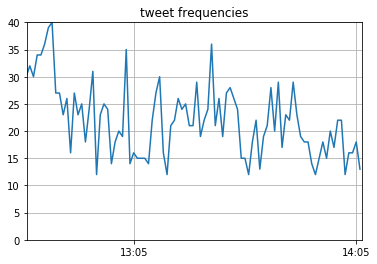

In [18]:
plt.figure(figsize=(17,14))
fig, ax=plt.subplots()
ax.grid(True)
ax.set_title('tweet frequencies')
hours = mdates.MinuteLocator(interval=60)
date_formatter = mdates.DateFormatter('%H:%M')
max_date = idx.max()
min_date = idx.min()
print(max_date, min_date, 'the date are ')
max_freq = per_minute.max()
ax.set_ylim(0,  max_freq)
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(date_formatter)
ax.set_xlim(min_date, max_date)
ax.plot(per_minute.index, per_minute)
plt.savefig('../images/tweet_per_time.png')

We can see from the figure that our tweet were collected from a 30 minutes time intervales (18:00-18:30) and we have the pick time at 18:19 with more that 14 tweets.
Since our time slot was too small we can't find when congolese tweet a lot , but the procedure is set.
If we had more tweet we could estimate with accuracy when the congolese tweet the most and advice some buisness to tweet a lot in that time.

### IV. Create a WordCloud

A wordcloud is a image which looks like a cloud filled with word where the word size is proportional to the frequency of word in a list of words.

We can also say : 
WordCloud is a technique to show which words are the most frequent among the given text.

let install the package 

In [19]:
#!pip install WordCloud

In [20]:
from wordcloud import WordCloud
import matplotlib.colors as colors

we will use our `term_count`counter to generate the world cloud 

In [21]:
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',normalize_plurals=True).generate_from_frequencies(term_counts)

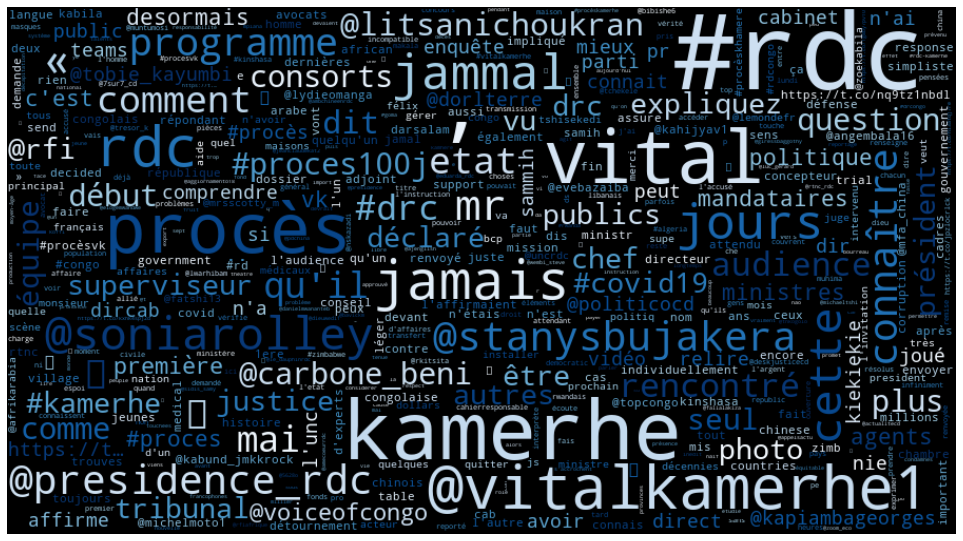

In [22]:
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Let us try to create a color map with DRC flag to make the wordcount made with DRC colors to see what will happen.

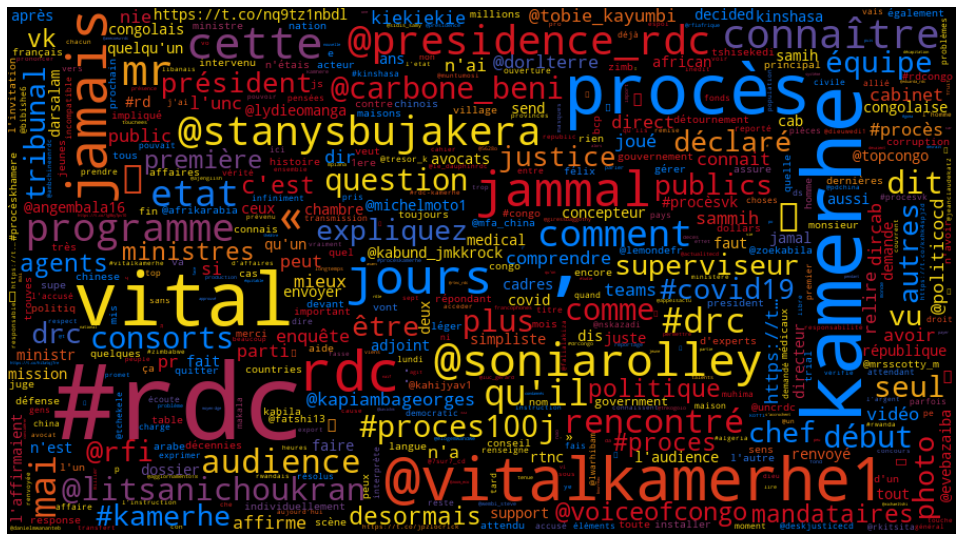

In [23]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap=drc_flag_color_map,normalize_plurals=True).generate_from_frequencies(term_counts)

plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### V. Improvement on twitter preprocessing 

In [24]:
import re
import preprocessor as tweet_preprocessor
import unicodedata
import many_stop_words

As you can see from the wordcount we find meaningless words, ie (c'est, different word counts for a word with hashtag and without hashtag, twitter handles(Idon't know yet if I should remove them or not))
We can use the approachs form [this blogpost](https://towardsdatascience.com/extracting-twitter-data-pre-processing-and-sentiment-analysis-using-python-3-0-7192bd8b47cf) to refractor our cleaning process.
- the first approach was to use a thrid part libary to clean the tweet. all the cleaning process are done in background with that libray. The library is called : *[tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/)*
- the second approach was to use additional steps after the normal prepocessin we didd, those steps are (emoji removals, replacing consecutives ascii char with spaces)f
- another prepocessing approach to do is to consider the fact that we are dealing with french tweets, we need to do some prepocessing due to the complexity of that language.
- I will also remove the # from the hashtags

In [25]:
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3',
    ])
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';(', '’:'
    ])
emoticons = emoticons_happy.union(emoticons_sad)
# let append emoticons to words_to remove

words_to_remove = set(words_to_remove).union(emoticons)

In [26]:
len(words_to_remove)

438

let remove also the emojis

In [27]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

let us remove also word with less than 2 characteres 

In [28]:
less_than_two_word = re.compile(r"w{1,2}")

In [29]:
def remove_nonlatin(s): 
    """
    remove non ascii character but keep accent
    """
    s = (ch for ch in s
         if unicodedata.name(ch).startswith(('LATIN', 'DIGIT', 'SPACE')))
    return ''.join(s)

In [30]:
def remove_emoji(text):
    """
    remove the emojis and non ascii char with space from the tweet
    """
    #after tweepy preprocessing the colon symbol left remain after      #removing mentions
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = ' '.join(re.findall(r'[\u0020-\u007F\u00A0-\u00FF\u0100-\u017F\u0180-\u024F]+', text))
    #remove emojis from tweet
    text = emoji_pattern.sub(r'', text)
    return text

Here is the final normalization process:
- remove_using_library
- remove_emoji()
- process_text()
- french_additional_step()

Let do it 

In [31]:
# I decide to keep and hashtags
tweet_preprocessor.set_options(tweet_preprocessor.OPT.URL, 
                               tweet_preprocessor.OPT.EMOJI,
                               tweet_preprocessor.OPT.RESERVED,
                               tweet_preprocessor.OPT.EMOJI, 
                               tweet_preprocessor.OPT.SMILEY,
                               tweet_preprocessor.OPT.NUMBER, 
                               tweet_preprocessor.OPT.MENTION)

- let apply french additionnal step by removing the stops word we have , we will use an addional library
add additional french word in list of word to remove

In [32]:
words_to_remove = words_to_remove.union(set(many_stop_words.get_stop_words('FR')))

In [86]:
words_to_remove = words_to_remove.union({'le', 'la', 'de', 'rdc'})

In [87]:
def get_term_count():
    """
    preporcess and return terms count from a file of tweets.
    Parm :
    path:  string : the path of the tweet files
    return a dictionary of term and the count of they occurences
    """
    term_counts = Counter()
    for tweet in get_tweets('16-10-2019', '17-10-2019'):
        text = tweet_preprocessor.clean(tweet.get('text'))
        text = text.replace('#', '')
        text = remove_emoji(text)
        tokens = process_text(text=text, tokenizer=TweetTokenizer(), words_to_remove=words_to_remove)
        term_counts.update(tokens)
    return term_counts

In [88]:
for tag, count in get_term_count().most_common(15):
    print("{}: {}".format(tag, count))

kamerhe: 539
vital: 403
procès: 389
jamais: 213
jammal: 173
jours: 168
«: 157
mr: 134
proces: 121
connaître: 110
programme: 107
covid: 101
etat: 97
qu'il: 93
mai: 92


#### Ploting the wordcount graph again.

In [89]:
drc_flag_color_map = colors.LinearSegmentedColormap.from_list("", ["#0080FF", 
                                                                   "#0080FF", 
                                                                   "#D00F20",
                                                                   "#D00F20",
                                                                   "#F5D715",
                                                                   "#F5D715"])
def generate_word_cloud(term_counts, color_map):
    return WordCloud(width=900,
                     height=500,
                     max_words=500,
                     max_font_size=100,
                     relative_scaling=0.5,
                     colormap=color_map,
                     normalize_plurals=True).generate_from_frequencies(term_counts)
def plot_word_cloud(word_cloud):
    plt.figure(figsize=(17,14))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.savefig('../images/DRC_WORD_COUNT.png')
    plt.axis("off")
    plt.show()

In [90]:
term_counts['ebola'] = term_counts['ebola']+ term_counts['ébola']

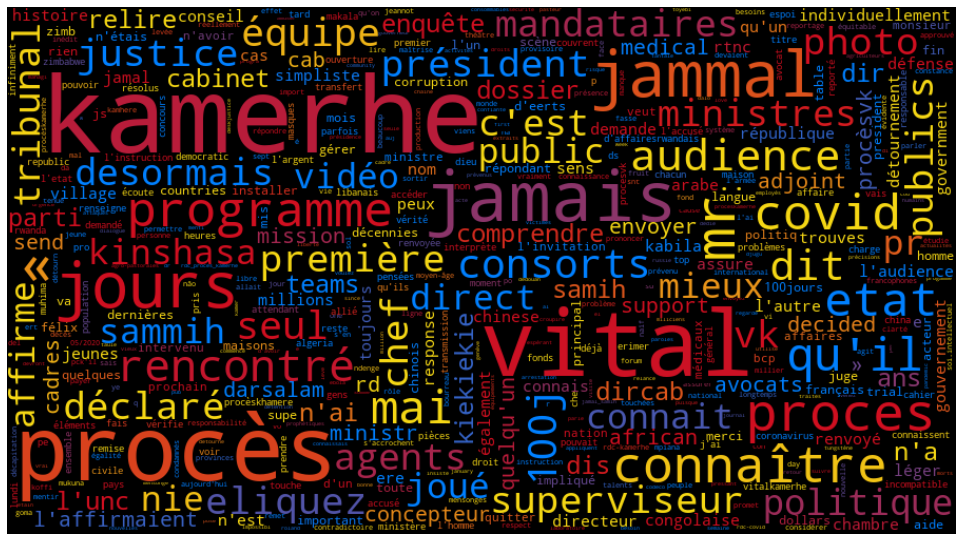

In [91]:
term_counts = get_term_count()
word_cloud = generate_word_cloud(term_counts, drc_flag_color_map)
plot_word_cloud(word_cloud)

In [92]:
len(term_counts)

3804

#### VI. TWITTER TOPIC MODELING

In [93]:
#Uncomment next line to download french stematiser
#! python -m spacy download fr_core_news_sm
#! python -m spacy download fr

In [43]:
import spacy
from io import BytesIO
from csv import writer 
from datetime import datetime
french_stematiser = spacy.load('fr')

Basically in this phase we wil train a machine learning model on our tweet to see which topics congoleses are talking about.

we will use co-occurence of word in a tweets , if word always appear together they form a topic.

We will use also the score of a word in a given topic to find the most relevants words in a given topic.

We wiil add another preprossesing step called stemming , stemming :
    
In the next step we stem the words in the list. This is essentially where we knock the end off the words. We do this so that similar words will be recognised as the same word by the algorithm

let try spacy for stematisation.

In [44]:
#!pip install -U spacy

In [45]:
def stematise_token(tokens):
    """
    replace word in token list  with his lemma:
    example : appelais  will become appele, plural will be replaced by their singular version, etc
    """

    doc = french_stematiser(' '.join(tokens))
    return [token.lemma_ for token in doc]

let us remove other words we may find in the tweets such as congo, congolais, rdc, drc since we already knows that those words are related to congo

In [46]:
congo_words = {'congo', 'congolais', 'rdc', 'drc', '-', 'https', 'rdc', 'rdcongo', 'drc', 'drcongo', 'tshisekedi'}
words_to_remove = words_to_remove.union(congo_words)

In [47]:
def prepocess_tweet(tweet):
    """
    Apply all the preprocessing process on a tweet and return the tweet as a text and tweet as list of tokens
    
    """
    text = tweet_preprocessor.clean(tweet.get('text'))
    text = text.replace('#', '')
    text = text.replace('-', '')
    text = text.replace("«", "")
    text = text.replace("»", "")
    text = text.replace("_", "")
    text = re.sub(r"\b\w{1}\b", "",text)
    text = re.sub(r"\b\w{2}\b", "",text)
    text = remove_emoji(text)
    tokens = process_text(text=text, tokenizer=TweetTokenizer(), words_to_remove=words_to_remove)
    tokens = stematise_token(tokens)
    return tokens

In [48]:
# the bellow function is not working but it's the most optimal https://stackoverflow.com/a/48287388/4683950 
def create_cleaned_df(output_path):
    """
    take an input file name of tweets , 
    cleaned them write them in a csv file and return a dataframe of cleaned tweets
    """
    output = BytesIO()
    csv_writer = writer(output)

    for tweet in get_tweets('16-10-2019', '17-10-2019'):
        csv_writer.writerow(tweet)
    output.seek(0) # we need to get back to the start of the BytesIO
    df = pd.read_csv(output)
    df.to_csv(output_path=output)
    return df

In [49]:
now = datetime.now()
today = now.strftime("%d-%m-%Y-%H-%M")
output_file_name='../data/cleanned_tweets_{}.csv'.format(today)
tweets_df = pd.DataFrame(columns=['cleanned_tweet'])
for tweet in get_tweets('16-10-2019', '17-10-2019'):
    tweets_df.loc[tweet.get('id')] = [' '.join(prepocess_tweet(tweet))]
tweets_df.to_csv(output_file_name)

In [50]:
tweets_df = pd.read_csv(output_file_name, index_col='Unnamed: 0')

In [51]:
print(output_file_name)

../data/cleanned_tweets_11-05-2020-17-17.csv


In [52]:
#tweets_df = create_cleaned_df('../data/query_drc.jsonl', '../data/cleanned_tweets.csv')

In [53]:
tweets_df.dropna(inplace=True)

The next step will be to apply now the algorithm and do topic modeling 

#### VI.b. sklearn phase 

To turn the text into a matrix*, where each row in the matrix encodes which words appeared in each individual tweet. We will also filter the words max_df=0.95 means we discard any words that appear in >90% of tweets. In this dataset I don’t think there are any words that are that common but it is good practice. We will also filter words using min_df=5, so words that appear in less than 25 tweets will be discarded. We discard high appearing words since they are too common to be meaningful in topics. We discard low appearing words because we won’t have a strong enough signal and they will just introduce noise to our model.

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

In [55]:
vectorizer = CountVectorizer(max_df=0.95, min_df=5, token_pattern='\w+|\$[\d\.]+|\S+')
transfromed_tweets = vectorizer.fit_transform(tweets_df.get('cleanned_tweet'))

In [56]:
# tf_feature_names tells us what word each column in the matric represents
tf_feature_names = vectorizer.get_feature_names()

In [66]:
number_of_topics = 5
topic_modeling_model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0, max_iter=200) 

In [67]:
topic_modeling_model.fit(transfromed_tweets)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=200,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [68]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [69]:
no_top_words = 10
display_topics(topic_modeling_model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,procès,157.1,an,39.2,jamais,157.4,kamerhe,231.2,proce,76.2
1,mai,77.8,vouloir,33.2,jammal,99.6,vital,230.1,audience,70.9
2,kamerhe,64.4,jamal,28.2,connaître,88.0,procès,214.3,100j,70.2
3,dire,52.4,arabe,27.2,rencontrer,86.2,jour,175.2,premier,70.2
4,kamerh,51.8,village,26.2,vital,84.9,programme,97.2,kamerhe,69.1
5,vital,49.8,..,23.2,dire,73.0,etat,95.0,jouer,47.2
6,superviseur,48.9,dossier,22.8,kamerhe,53.1,covid,77.3,comprendre,43.2
7,avocat,48.2,demande,22.2,sammih,45.2,public,70.9,enquête,42.2
8,équipe,47.9,toujours,22.2,kamerh,41.0,jammal,64.1,mieux,42.2
9,justice,45.7,affaire,20.3,vidéo,40.2,photo,63.2,envoyer,41.2


### let us visualize the results

In [70]:
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(topic_modeling_model, transfromed_tweets, vectorizer, mds='tsne')
panel

/Users/es.py/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3     -153.866089 -155.159363       1        1  28.059225
4       43.543095 -285.909302       2        1  20.105261
2        8.300098  119.925049       3        1  19.899246
0      152.884491  -66.715866       4        1  19.302593
1     -231.222733   68.621086       5        1  12.633674, topic_info=    Category        Freq           Term       Total  loglift  logprob
375  Default  369.000000         procès  369.000000  30.0000  30.0000
240  Default  164.000000           jour  164.000000  29.0000  29.0000
231  Default  204.000000         jamais  204.000000  28.0000  28.0000
411  Default   83.000000     rencontrer   83.000000  27.0000  27.0000
100  Default  138.000000      connaître  138.000000  26.0000  26.0000
234  Default  165.000000         jammal  165.000000  25.0000  25.0000
136  Default  120.000000           dire  120.000000  24.0000  24.0000
383  Default   91.000000      programme   91.000000  23.0000  23.0000
4    Default   67.000000           100j   67.000000  22.0000  22.0000
363  Default   67.000000        premier   67.000000  21.0000  21.0000
279  Default   88.000000            mai   88.000000  20.0000  20.0000
52   Default  108.000000       audience  108.000000  19.0000  19.0000
175  Default  104.000000           etat  104.000000  18.0000  18.0000
370  Default  102.000000          proce  102.000000  17.0000  17.0000
514  Default  382.000000          vital  382.000000  16.0000  16.0000
33   Default   39.000000             an   39.000000  15.0000  15.0000
57   Default   46.000000         avocat   46.000000  14.0000  14.0000
252  Default  394.000000        kamerhe  394.000000  13.0000  13.0000
353  Default   59.000000          photo   59.000000  12.0000  12.0000
239  Default   45.000000          jouer   45.000000  11.0000  11.0000
398  Default   98.000000         public   98.000000  10.0000  10.0000
518  Default   33.000000        vouloir   33.000000   9.0000   9.0000
441  Default   44.000000         sammih   44.000000   8.0000   8.0000
468  Default   57.000000    superviseur   57.000000   7.0000   7.0000
414  Default   41.000000       renvoyer   41.000000   6.0000   6.0000
534  Default   63.000000         équipe   63.000000   5.0000   5.0000
88   Default   42.000000     comprendre   42.000000   4.0000   4.0000
163  Default   41.000000        enquête   41.000000   3.0000   3.0000
298  Default   41.000000          mieux   41.000000   2.0000   2.0000
147  Default   52.000000       déclarer   52.000000   1.0000   1.0000
..       ...         ...            ...         ...      ...      ...
347   Topic5   13.982541           pays   14.744871   2.0157  -4.5747
337   Topic5   13.001065        parfois   13.760066   2.0121  -4.6475
527   Topic5   13.001065         écoute   13.760066   2.0121  -4.6475
413   Topic5   13.001065      renseigne   13.760066   2.0121  -4.6475
436   Topic5   13.001065       résoudre   13.760066   2.0121  -4.6475
225   Topic5   13.001063      interprèt   13.760066   2.0121  -4.6475
172   Topic5   12.016135          espoi   12.775136   2.0076  -4.7263
132   Topic5   11.029900           dieu   11.790169   2.0021  -4.8119
352   Topic5   11.027692         peuple   11.790081   2.0020  -4.8121
270   Topic5   10.046275           lire   10.805277   1.9960  -4.9054
418   Topic5   10.045942        respect   10.805264   1.9959  -4.9054
350   Topic5    9.061340      permettre    9.820347   1.9884  -5.0085
502   Topic5    9.060533        urgence    9.820323   1.9883  -5.0086
312   Topic5    9.060406           mort    9.820308   1.9883  -5.0086
23    Topic5    9.060036           agir    9.820298   1.9882  -5.0087
376   Topic5    9.059814  procèskamerhe    9.820279   1.9882  -5.0087
187   Topic5    9.059637           fond    9.820280   1.9882  -5.0087
355   Topic5    9.059411          pièce    9.820275   1.9882  -5.0087
125   Topic5   21.893434        demande   32.192530

In [71]:
topic_model_nmf = NMF(n_components=5, random_state=0, alpha=.1, l1_ratio=.5)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=5, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [72]:
topic_model_nmf.fit(transfromed_tweets)

NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=5, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [76]:
transfromed_tweets

<1870x541 sparse matrix of type '<class 'numpy.int64'>'
	with 10515 stored elements in Compressed Sparse Row format>

In [73]:
no_top_words = 10
display_topics(topic_model_nmf, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights
0,kamerhe,2.2,jamais,5.0,proce,2.3,vital,3.5,procès,4.9
1,vital,2.1,rencontrer,1.7,audience,2.2,kamerhe,3.4,équipe,1.4
2,etat,2.1,kamerhe,1.7,100j,2.0,jour,2.9,superviseur,1.3
3,public,2.0,jammal,1.6,premier,1.7,connaître,1.6,kamerh,1.2
4,procès,2.0,dire,1.5,jouer,1.5,programme,1.4,dire,1.2
5,ministre,1.9,sammih,1.4,comprendre,1.5,jammal,1.4,mai,1.1
6,consort,1.8,vital,1.3,mieux,1.5,déclarer,1.3,dir,1.1
7,agent,1.7,vidéo,1.3,enquête,1.5,eliquez,1.3,adjoint,1.1
8,mandataire,1.7,envoyer,0.4,relire,1.5,photo,1.2,cab,1.1
9,desormai,1.7,conner,0.4,également,0.4,procès,0.8,ministr,1.1


I think I have something to understand tommorrow moring ,
now I can level up on the others topics